In [1]:
#import required classes and packages
from lightgbm import LGBMClassifier
from web3 import Web3, HTTPProvider
import json
from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
import pandas as pd #pandas to read and explore dataset
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import timeit
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   

Using TensorFlow backend.
c:\Users\srika\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\srika\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\srika\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#function to initialize Blockchain contract to save and get local models
from web3 import Web3, HTTPProvider
import json

def getContract():
    blockchain_address = 'http://127.0.0.1:8545'
    web3 = Web3(HTTPProvider(blockchain_address))
    web3.eth.defaultAccount = web3.eth.accounts[0]
    compiled_contract_path = 'MLContract.json' #Smart Contract to manage ML model weights
    deployed_contract_address = '0xaA11fD9D02Ac2Ab7C00722130220626036596FDb' #contract address
    with open(compiled_contract_path) as file:
        contract_json = json.load(file)  # load contract info as JSON
        contract_abi = contract_json['abi']  # fetch contract's abi - necessary to call its functions
    file.close()
    contract = web3.eth.contract(address=deployed_contract_address, abi=contract_abi)
    return contract, web3
contract, web3 = getContract()
print("Blockchain Contract Deployment & Connection Successful")

Blockchain Contract Deployment & Connection Successful


In [3]:
from web3 import Web3
import json

#
web3 = Web3(Web3.HTTPProvider("http://127.0.0.1:8545"))
if not web3.isConnected():
    print(" Web3 is not connected to local blockchain")
    exit()


with open("C:\\Users\\srika\\hello-eth\\build\\contracts\\MLContract.json") as f:

    contract_json = json.load(f)
    abi = contract_json['abi']


contract_address = "0xaA11fD9D02Ac2Ab7C00722130220626036596FDb" 


contract = web3.eth.contract(address=contract_address, abi=abi)


web3.eth.default_account = web3.eth.accounts[0]



def add_sample_model():
    try:
        tx_hash = contract.functions.saveBestModel(
            "model1",
            "0.12,0.34",
            "0.56",
            "class1,class2"
        ).transact()
        web3.eth.wait_for_transaction_receipt(tx_hash)
        print("✅ Sample model saved.")
    except Exception as e:
        print("❌ Error saving model:", e)


# ✅ Function to get list of weights from blockchain
def getWeightList():
    weightList = []

    try:
        count = contract.functions.getModelCount().call()
        print(f"📦 Total models on blockchain: {count}")
    except Exception as e:
        print("❌ Error while fetching model count:", e)
        return []

    for i in range(count):
        try:
            print(f"🔍 Fetching model at index {i}")
            model_name = contract.functions.getModelName(i).call()
            model_weight = contract.functions.getWeight(i).call()
            model_intercept = contract.functions.getIntercept(i).call()
            model_classes = contract.functions.getClasses(i).call()

            weightList.append([model_name, model_weight, model_intercept, model_classes])
        except Exception as e:
            print(f"⚠️ Error fetching model at index {i}:", e)

    return weightList


# ✅ RUN:
# add_sample_model()  # Uncomment this line if running for first time
weightList = getWeightList()
print("✅ Blockchain Model Weight List Initialized:", weightList)


📦 Total models on blockchain: 0
✅ Blockchain Model Weight List Initialized: []


In [4]:
#loading and displaying IoT23 attack dataset
import pandas as pd
dataset = pd.read_csv("Dataset/data.csv")
dataset

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
2,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.00,0.00,1,0
3,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1,0
4,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
28208,8,CASH_IN,141811.33,C1507170630,2596606.93,2738418.25,C746359178,742685.98,1793011.10,0,0
28209,8,CASH_IN,632085.47,C1414128792,2738418.25,3370503.73,C264685626,1736548.55,0.00,0,0
28210,8,CASH_IN,150605.27,C1540927,3370503.73,3521109.00,C75629578,1075492.86,707849.71,0,0
28211,8,CASH_IN,53634.28,C1781243086,3521109.00,3574743.28,C464246030,352529.81,0.00,0,0


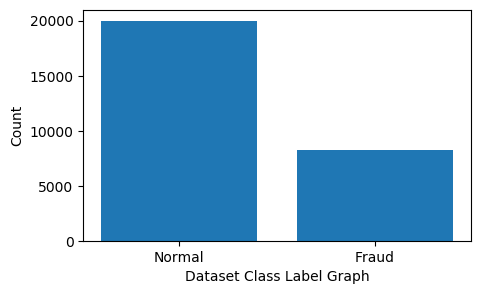

In [5]:
#visualizing different attack class labels count found in dataset
import numpy as np
import matplotlib.pyplot as plt


names, count = np.unique(dataset['isFraud'], return_counts = True)
labels = ['Normal', 'Fraud']
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (5, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.show()

In [6]:
#applying dataset processing technique to convert non-numeric data to numeric data
from sklearn.preprocessing import LabelEncoder

label_encoder = []
columns = dataset.columns
types = dataset.dtypes.values
for j in range(len(types)):
    name = types[j]
    if name == 'object': #finding column with object type
        le = LabelEncoder()
        dataset[columns[j]] = pd.Series(le.fit_transform(dataset[columns[j]].astype(str)))#encode all str columns to numeric
        label_encoder.append([columns[j], le])
Y = dataset['isFraud'].ravel()
dataset.drop(['isFraud'], axis = 1,inplace=True)
dataset.fillna(dataset.mean(), inplace = True)#replace misisng values with mean
dataset

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,1,4,181.00,4425,181.00,0.00,8104,0.00,0.00,0
1,1,1,181.00,25850,181.00,0.00,7216,21182.00,0.00,0
2,1,4,2806.00,6052,2806.00,0.00,10356,0.00,0.00,0
3,1,1,2806.00,16162,2806.00,0.00,41,26202.00,0.00,0
4,1,4,20128.00,5404,20128.00,0.00,4627,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
28208,8,0,141811.33,7337,2596606.93,2738418.25,9152,742685.98,1793011.10,0
28209,8,0,632085.47,5960,2738418.25,3370503.73,6541,1736548.55,0.00,0
28210,8,0,150605.27,7891,3370503.73,3521109.00,9208,1075492.86,707849.71,0
28211,8,0,53634.28,11444,3521109.00,3574743.28,7619,352529.81,0.00,0


In [7]:
#dataset shuffling & Normalization
from sklearn.preprocessing import StandardScaler

X = dataset.values
scaler = StandardScaler()
X = scaler.fit_transform(X)#normalize dataset values
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle dataset values
X = X[indices]
Y = Y[indices]
print("Dataset shuffling & Normalization Completed")

Dataset shuffling & Normalization Completed


In [8]:
#applying smote algorithm to handle imbalance data
from imblearn.over_sampling import SMOTE

print("Total records available in dataset before applying SMOTE = "+str(X.shape[0]))
smote = SMOTE()
X, Y = smote.fit_resample(X, Y)
print("Total records available in dataset after applying SMOTE = "+str(X.shape[0]))

Total records available in dataset before applying SMOTE = 28213
Total records available in dataset after applying SMOTE = 40000
Total records available in dataset after applying SMOTE = 40000


In [9]:
#now dividing dataset into different difficulty levels to calculate training time where difficulty 1 will be 
#containing 10000 records and difficulty level 2 contains 30000 records
diff_1_X = X[0:10000]
diff_1_Y = Y[0:10000]
diff_2_X = X[10000:X.shape[0]]
diff_2_Y = Y[10000:X.shape[0]]
print("Difficulty Levels Created")

Difficulty Levels Created


In [10]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []
mining_time = []

In [11]:
#function to calculate all algorithms metrics like accuracy, precision etc
def calculateMetrics(algorithm, predict, y_test, run_time):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    mining_time.append(run_time)
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f)) 
    print(algorithm+" Mining Time : "+str(run_time))
    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(6, 3)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()  

In [12]:
#function to train all algorithms increment and then report best model to Blockchain
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns






def trainIncrement(algorithm, algorithm_name, XX, YY, initial, weights, intercept, classes):
    X_train, X_test, y_train, y_test = train_test_split(XX, YY, test_size = 0.2)#split data to train and test
    start = timeit.default_timer()
    if initial == False:  #if model already trained then set old weights to trained incrementally
        algorithm.coef_ = weights
        algorithm.intercept_ = intercept
        algorithm.classes_ = classes
    algorithm.partial_fit(X_train, y_train, np.unique(YY))#train on new data and incrment model updates
    predict = algorithm.predict(X_test)#perfrom prediction on test data
    weights = algorithm.coef_   #obtained model weights
    intercept = algorithm.intercept_
    classes_details = algorithm.classes_
    end = timeit.default_timer()
    run_time = end - start
    calculateMetrics(algorithm_name, predict, y_test, run_time)#call function to calculate accuracy and other metrics
    return weights, intercept, classes_details

PAC Initial Accuracy  :  98.85000000000001
PAC Initial Precision : 99.20027816411682
PAC Initial Recall    : 98.03418803418805
PAC Initial FScore    : 98.59430000877035
PAC Initial Mining Time : 0.008602400000000898


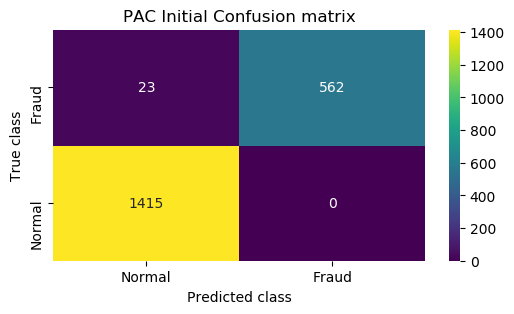

In [13]:
#train PAC as initial run with difficulty1
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


pac = PassiveAggressiveClassifier(warm_start=True)
pac_initial_weights, pac_initial_intercept, pac_initial_classes = trainIncrement(pac, "PAC Initial", diff_1_X, diff_1_Y, True, None, None, None)

PAC Increment Accuracy  :  98.68333333333334
PAC Increment Precision : 98.49439889821502
PAC Increment Recall    : 98.85346525436931
PAC Increment FScore    : 98.65669008720886
PAC Increment Mining Time : 0.013247400000011567


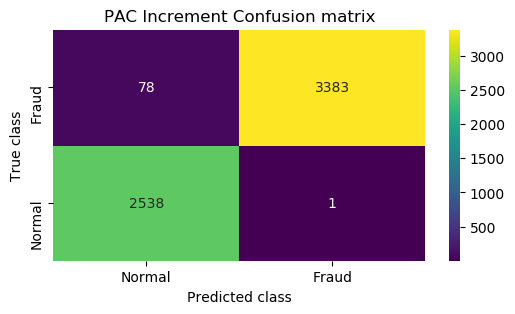

In [14]:
#train pac with increment learning using difficulty level2
pac_increment_weights, pac_increment_intercept, pac_increment_classes = trainIncrement(pac, "PAC Increment", diff_2_X, diff_2_Y, False,
                                                     pac_initial_weights, pac_initial_intercept, pac_initial_classes)


SGD Initial Accuracy  :  98.75
SGD Initial Precision : 99.02654486943706
SGD Initial Recall    : 97.89135502479307
SGD Initial FScore    : 98.4387446132786
SGD Initial Mining Time : 0.006081100000017159


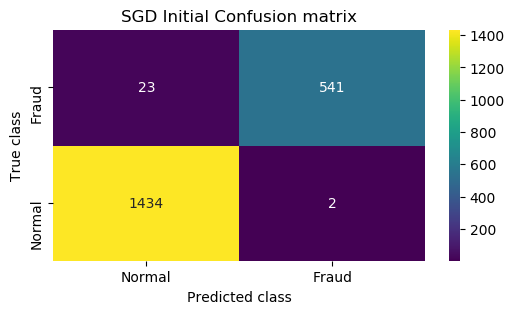

In [15]:
#train SGD as initial run with difficulty1
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(warm_start=True)
sgd_initial_weights, sgd_initial_intercept, sgd_initial_classes = trainIncrement(sgd, "SGD Initial", diff_1_X, diff_1_Y, True, None, None, None)

SGD Increment Accuracy  :  98.96666666666667
SGD Increment Precision : 98.86204189181854
SGD Increment Recall    : 99.04522940378521
SGD Increment FScore    : 98.9485304525932
SGD Increment Mining Time : 0.01191939999998226


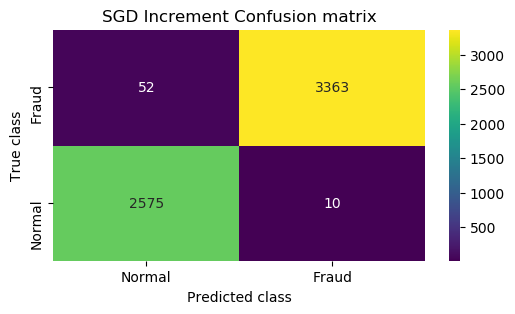

In [16]:
#train SGD with increment learning using difficulty level2
sgd_increment_weights, sgd_increment_intercept, sgd_increment_classes = trainIncrement(sgd, "SGD Increment", diff_2_X, diff_2_Y, False,
                                                     sgd_initial_weights, sgd_initial_intercept, sgd_initial_classes)


Perceptron Initial Accuracy  :  98.95
Perceptron Initial Precision : 99.25106990014265
Perceptron Initial Recall    : 98.30371567043619
Perceptron Initial FScore    : 98.75993198522193
Perceptron Initial Mining Time : 0.004737599999998565


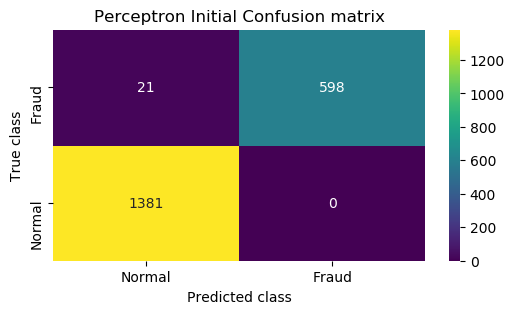

In [17]:
#train Perceptron as initial run with difficulty1
from sklearn.linear_model import Perceptron

perceptron = Perceptron(warm_start=True)
per_initial_weights, per_initial_intercept, per_initial_classes = trainIncrement(perceptron, "Perceptron Initial", diff_1_X, diff_1_Y, True, None, None, None)

Perceptron Increment Accuracy  :  97.95
Perceptron Increment Precision : 97.97118461431305
Perceptron Increment Recall    : 97.83932173957454
Perceptron Increment FScore    : 97.90313453258695
Perceptron Increment Mining Time : 0.014166600000010021


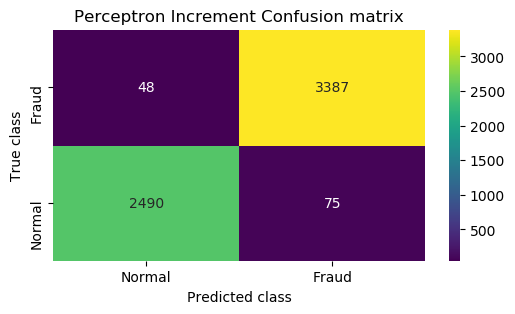

In [18]:
#train Perceptron with increment learning using difficulty level2
per_increment_weights, per_increment_intercept, per_increment_classes = trainIncrement(perceptron, "Perceptron Increment", diff_2_X, diff_2_Y, False,
                                                     per_initial_weights, per_initial_intercept, per_initial_classes)


BernoulliNB Accuracy  :  95.6
BernoulliNB Precision : 95.63203725558994
BernoulliNB Recall    : 93.55926588565421
BernoulliNB FScore    : 94.51961976125472
BernoulliNB Mining Time : 0.007220400000022664


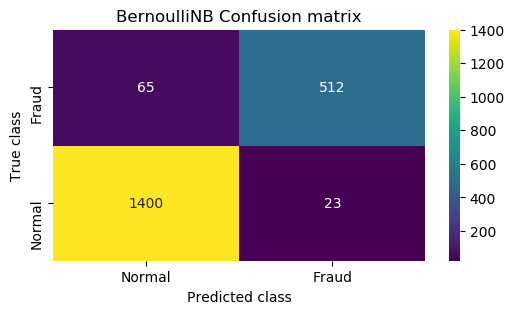

In [19]:
#train naive bayes as initial run with difficulty1
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb_initial_weights, bnb_initial_intercept, bnb_initial_classes = trainIncrement(bnb, "BernoulliNB", diff_1_X, diff_1_Y, True, None, None, None)

BernoulliNB Increment Accuracy  :  92.58333333333333
BernoulliNB Increment Precision : 92.27336733299687
BernoulliNB Increment Recall    : 93.11755679824752
BernoulliNB Increment FScore    : 92.49716557246585
BernoulliNB Increment Mining Time : 0.02041189999999915


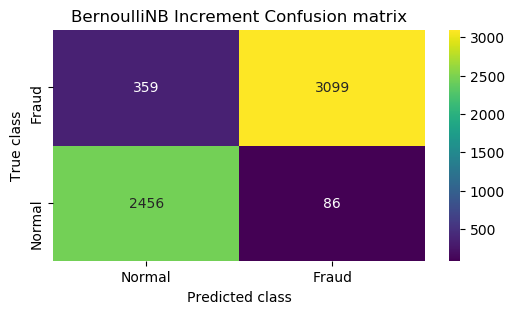

In [20]:
#train naive bayes with increment learning using difficulty level2
bnb_increment_weights, bnb_increment_intercept, bnb_increment_classes = trainIncrement(bnb, "BernoulliNB Increment", diff_2_X, diff_2_Y, True,
                                                     bnb_initial_weights, bnb_initial_intercept, bnb_initial_classes)

In [21]:
#function to train lightGBM algorithm
def trainLGBMIncrement(algorithm, algorithm_name, XX, YY):
    X_train, X_test, y_train, y_test = train_test_split(XX, YY, test_size = 0.2)#split data to train and test
    start = timeit.default_timer()
    algorithm.fit(X_train, y_train)
    predict = algorithm.predict(X_test)
    end = timeit.default_timer()
    run_time = end - start
    calculateMetrics(algorithm_name, predict, y_test, run_time)#call function to calculate accuracy and other metrics    

[LightGBM] [Info] Number of positive: 2321, number of negative: 5679
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2044
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290125 -> initscore=-0.894777
[LightGBM] [Info] Start training from score -0.894777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Initial Accuracy  :  99.9
LightGBM Initial Precision : 99.93036211699165
LightGBM Initial Recall    : 99.82332155477032
LightGBM Initi

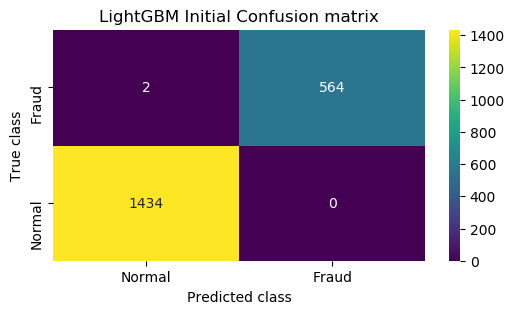

In [22]:
#train lightGBM as initial run with difficulty1
from lightgbm import LGBMClassifier

lgbm_cls = LGBMClassifier()
trainLGBMIncrement(lgbm_cls, "LightGBM Initial", diff_1_X, diff_1_Y)

[LightGBM] [Info] Number of positive: 13661, number of negative: 10339
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.569208 -> initscore=0.278622
[LightGBM] [Info] Start training from score 0.278622
LightGBM Increment Accuracy  :  99.93333333333332
LightGBM Increment Precision : 99.92668371696504
LightGBM Increment Recall    : 99.93692369540739
LightGBM Increment FScore    : 99.93179182090715
LightGBM Increment Mining Time : 0.25913790000001313
LightGBM Increment Accuracy  :  99.93333333333332
LightGBM Increment Precision : 99.92668371696504
LightGBM Increment Recall    : 99.93692369540739
LightGBM Increment FScore    : 99.93179182090715
LightGBM Increment Mining Time : 0.25913790000001313


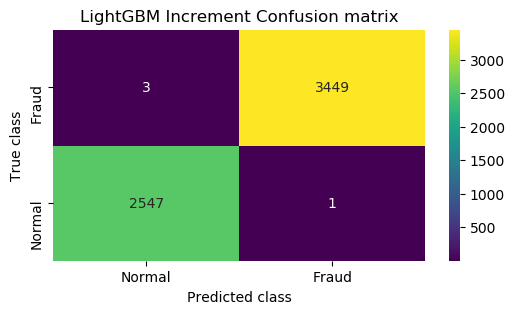

In [23]:
#train lightGBM  with increment learning using difficulty level2
trainLGBMIncrement(lgbm_cls, "LightGBM Increment", diff_2_X, diff_2_Y)

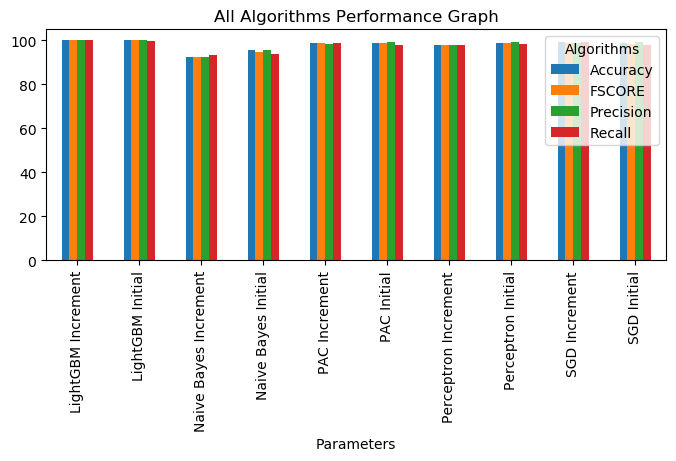

In [24]:
#plot all algorithm performance in tabukar format
df = pd.DataFrame([['PAC Initial','Accuracy',accuracy[0]],['PAC Initial','Precision',precision[0]],['PAC Initial','Recall',recall[0]],['PAC Initial','FSCORE',fscore[0]],
                   ['PAC Increment','Accuracy',accuracy[1]],['PAC Increment','Precision',precision[1]],['PAC Increment','Recall',recall[1]],['PAC Increment','FSCORE',fscore[1]],
                   ['SGD Initial','Accuracy',accuracy[2]],['SGD Initial','Precision',precision[2]],['SGD Initial','Recall',recall[2]],['SGD Initial','FSCORE',fscore[2]],
                   ['SGD Increment','Accuracy',accuracy[3]],['SGD Increment','Precision',precision[3]],['SGD Increment','Recall',recall[3]],['SGD Increment','FSCORE',fscore[3]],
                   ['Perceptron Initial','Accuracy',accuracy[4]],['Perceptron Initial','Precision',precision[4]],['Perceptron Initial','Recall',recall[4]],['Perceptron Initial','FSCORE',fscore[4]],
                   ['Perceptron Increment','Accuracy',accuracy[5]],['Perceptron Increment','Precision',precision[5]],['Perceptron Increment','Recall',recall[5]],['Perceptron Increment','FSCORE',fscore[5]],
                   ['Naive Bayes Initial','Accuracy',accuracy[6]],['Naive Bayes Initial','Precision',precision[6]],['Naive Bayes Initial','Recall',recall[6]],['Naive Bayes Initial','FSCORE',fscore[6]],
                   ['Naive Bayes Increment','Accuracy',accuracy[7]],['Naive Bayes Increment','Precision',precision[7]],['Naive Bayes Increment','Recall',recall[7]],['Naive Bayes Increment','FSCORE',fscore[7]],
                   ['LightGBM Initial','Accuracy',accuracy[8]],['LightGBM Initial','Precision',precision[8]],['LightGBM Initial','Recall',recall[8]],['LightGBM Initial','FSCORE',fscore[8]],
                   ['LightGBM Increment','Accuracy',accuracy[9]],['LightGBM Increment','Precision',precision[9]],['LightGBM Increment','Recall',recall[9]],['LightGBM Increment','FSCORE',fscore[9]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(8, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [25]:
#display all algorithm performnace
import pandas as pd
algorithms = ['PAC Initial', 'PAC Increment', 'SGD Initial', 'SGD Increment', 'Perceptron Initial', 'Perceptron Increment',
             'Naive Bayes Initial', 'Naive Bayes Increment', 'LightGBM Initail', 'LightGBM Increment']
data = []
for i in range(len(accuracy)):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data  

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,PAC Initial,98.850000,99.200278,98.034188,98.594300
1,PAC Increment,98.683333,98.494399,98.853465,98.656690
2,SGD Initial,98.750000,99.026545,97.891355,98.438745
3,SGD Increment,98.966667,98.862042,99.045229,98.948530
4,Perceptron Initial,98.950000,99.251070,98.303716,98.759932
5,Perceptron Increment,97.950000,97.971185,97.839322,97.903135
6,Naive Bayes Initial,95.600000,95.632037,93.559266,94.519620
7,Naive Bayes Increment,92.583333,92.273367,93.117557,92.497166
8,LightGBM Initail,99.900000,99.930362,99.823322,99.876661
9,LightGBM Increment,99.933333,99.926684,99.936924,99.931792


In [26]:
def getWeightsData(value):
    return " ".join(str(x) for x in value)

In [27]:
from web3 import Web3, HTTPProvider
import json

# Connect to Ganache
web3 = Web3(HTTPProvider("http://127.0.0.1:8545"))
assert web3.isConnected(), "❌ Ganache not connected"
from_account = web3.eth.accounts[0]

# Load compiled contract ABI and deployed address
with open("MLContract.json") as f:
    contract_json = json.load(f)
abi = contract_json['abi']
contract_address = web3.toChecksumAddress("0x949c4c2964477ED2eb56b8793a05F3f1E5f0F0A0")

# Get contract instance
contract = web3.eth.contract(address=contract_address, abi=abi)

# Define weightList to track if model already exists
weightList = []

# Helper to convert weights to JSON strings
def getWeightsData(param):
    return json.dumps([float(x) for x in param])

# Dummy model data
model_name = "SGD Increment"
model_weights = [19.88, 0.19, -0.52, -0.65, 7.77, -7.73, -0.81, 2.08, -1.06, 0.05]
model_intercept = [9.55]
model_classes = [0.0, 1.0]

# Log before storing
print(f"\n🔎 Model: {model_name}")
print("Weights:", getWeightsData(model_weights))
print("Intercept:", getWeightsData(model_intercept))
print("Classes:", getWeightsData(model_classes))

# Store or update model on blockchain
if len(weightList) == 0:
    try:
        tx_hash = contract.functions.saveBestModel(
            model_name,
            getWeightsData(model_weights),
            getWeightsData(model_intercept),
            getWeightsData(model_classes)
        ).transact({'from': from_account, 'gas': 3000000})

        weightList.append([
            model_name,
            getWeightsData(model_weights),
            getWeightsData(model_intercept),
            getWeightsData(model_classes)
        ])

        receipt = web3.eth.waitForTransactionReceipt(tx_hash)

        print("✅ Model saved successfully.\nTransaction Hash:", receipt.transactionHash.hex())

    except ValueError as e:
        print("❌ Error saving model to blockchain:", e)

else:
    try:
        tx1 = contract.functions.updateWeight(
            0, getWeightsData(model_weights)
        ).transact({'from': from_account, 'gas': 3000000})

        tx2 = contract.functions.updateHashcode(
            0, getWeightsData(model_intercept)
        ).transact({'from': from_account, 'gas': 3000000})

        tx3 = contract.functions.updateDate(
            0, getWeightsData(model_classes)
        ).transact({'from': from_account, 'gas': 3000000})

        receipt = web3.eth.wait_for_transaction_receipt(tx3)
        print("✅ Model updated successfully.\nTransaction Hash:", receipt.transactionHash.hex())

    except ValueError as e:
        print("❌ Error updating model on blockchain:", e)



🔎 Model: SGD Increment
Weights: [19.88, 0.19, -0.52, -0.65, 7.77, -7.73, -0.81, 2.08, -1.06, 0.05]
Intercept: [9.55]
Classes: [0.0, 1.0]
✅ Model saved successfully.
Transaction Hash: 0xd610a4bd5837f169af45012b43cd0223d114fcb27d720a0091ab221c8a157bef


In [28]:
#import flask library
from flask import Flask, render_template, request, redirect, url_for, session,send_from_directory

In [29]:
app = Flask(__name__)
app.secret_key = 'welcome'

In [30]:
from flask_cors import CORS
CORS(app)

In [31]:
from flask import jsonify
@app.route('/predict', methods=['POST'])
def PredictAction():
    sgd = SGDClassifier(warm_start=True)
    sgd.coef_ = sgd_increment_weights
    sgd.intercept_ = sgd_increment_intercept
    sgd.classes_ = sgd_increment_classes
    testData = pd.read_csv("Dataset/testData.csv")
    temp = testData.values
    for i in range(len(label_encoder)):
        le = label_encoder[i]
        testData[le[0]] = pd.Series(le[1].transform(testData[le[0]].astype(str)))
    testData.fillna(dataset.mean(), inplace = True) 
    testData = testData.values
    testData = scaler.transform(testData)
    predict = sgd.predict(testData)
    transactions = []
    for i in range(len(predict)):
        color = "green" if predict[i] == 0 else "red"
        summary = f"Test Data = {temp[i]} | Predicted Transaction ===> <span style='color:{color}'>{labels[predict[i]]}</span>"
        transactions.append({
            "data": temp[i].tolist(),
            "prediction": str(labels[predict[i]]),
            "color": color,
            "summary": summary
        })
    return jsonify({"transactions": transactions})

In [32]:
from flask import jsonify
@app.route('/AdminLoginAction', methods=['POST'])
def AdminLoginAction():
    user = request.form.get('t1')
    password = request.form.get('t2')
    if user == "admin" and password == "admin":
        return jsonify({"success": True, "message": f"Welcome {user}"})
    else:
        return jsonify({"success": False, "message": "Invalid login details"})

In [ ]:
# your_script.py
if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit

 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [14/Oct/2025 14:27:57] "POST /AdminLoginAction HTTP/1.1" 200 -
127.0.0.1 - - [14/Oct/2025 14:27:57] "POST /AdminLoginAction HTTP/1.1" 200 -
127.0.0.1 - - [14/Oct/2025 14:28:44] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [14/Oct/2025 14:28:44] "POST /predict HTTP/1.1" 200 -
